# Gaussian Process Latent Variable Model (GP-LVM) for Dimensionality Reduction

A wide variety of dimensionality reduction problems can be solved with the Gaussian Process Latent Variable Model (GP-LVM). For this, we simply use a GP to map from a latent variable to an observed one - sampling from the latent will serve as input for the GP.

For reference see: http://jmlr.csail.mit.edu/papers/volume6/lawrence05a/lawrence05a.pdf


### Scientific value:

One use of GPs is dimensionality reduction. For dimensionality reduction, one only observes the output of a GP. The input of the GP is sampled from a
latent variable - which is why this approach is called Gaussian Process Latent Variable Model
(GP-LVM). We use one GP to map from the latent variable to one dimension in the
observed space. Thus, if the latent (reduced) space is of dimension n and the
observed space is of dimension m (where n < m), we need m indepedent GP that can process
input of dimension n.

Inference for this creates a challenge, because one has to infer all the latent input values
for input output-pairs and the hyper-parameters for each individual GP.  We are going to need gradients to ensure
that this works. 

Since the dimensionality of the latent space n can be larger than 1, we need
more diverse inputs for a GP as well. Specifically, we require multivariate
inputs due to n >= 1. Pleaes note that this task coincides with another requirement 
for the GPmem paper - that is to be able to have scalar input for a GP as well.

The aim is to get this example to run before writing sustainable code and a
"good" library.




### Deliverables

What currently causes a crash is (a) gradient-based inference and (b) multivariate input for GPs. For now, we only need to ensure that a GP can process input in  form of:

- scalars;

- 1- d arrays (to model vectors);

- multi-dimensional arrays (to model matrices);


a) **More diverse input for GPs.**

In the future, we should allow GPs to cope with all kinds of input that can be used for a covariance function. For now, we only focus on the three above. 
Currently, this crashes merely due to typing of the GP-SP but I suspect that the vectorization of the input will cause different crash - even when we change the input of a GP to "types.AnyType()".

=> Who is delivering this? Ulli with Taylor's help.


b) **Gradient-based inference.** For now, gradient ascent inference is sufficient.

=> Who is delivering this? Taylor with Ulli's help.

### Goal: Dimensionality Reduction

We want to perform dimensionality reduction using spherical data observed in 3-d space which we would like to map to a shere in 2-d space. According to this paper [Neal (2005)](http://jmlr.csail.mit.edu/papers/volume6/lawrence05a/lawrence05a.pdf) GP-LVM for likelihood optimization to find hyper-parameters in combination with independent GPs and linear kernels is equivalent to PCA. We therefore aim to produce a plot similar to Fig 3.

Currently multivariate input for GPs is not implemented. We therefore deploy a "fake"-GP (see program_part_4, below) that stubbs the GP-LVM program. The aim is (i) to allow multivariate input to GPs to (ii) perform gradient ascent to make Fig. 2 similar to Fig 3 (a mock-up - produced with Scikit Learn's implementation of PCA; we simply plot the first and second component). Fig 2 is currently stubbed due to the fake GP.

In [2]:
from venture import shortcuts
import numpy as np
import pandas as pd
#import seaborn as sns
import json
import codecs
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy
import math
%matplotlib inline  

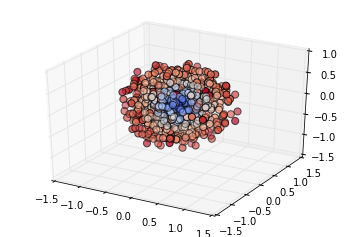

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
### dataset size must be a square number
n = 1000
phi = np.random.uniform(0,2 *math.pi, n)
cos_theta = np.random.uniform(-1,1,n)
r = np.random.uniform(0,1,n)
x = r * np.sqrt(1 - cos_theta**2) * np.cos(phi)
y = r * np.sqrt(1 - cos_theta**2) * np.sin(phi)
z = r * cos_theta
color_value = [scipy.spatial.distance.euclidean(obs[0],[0,0,0]) for obs in zip(x,y,z)]
Greens = plt.get_cmap('coolwarm')
cmap = Greens(r)

ax.scatter(x, y, z,  s=50, c=cmap)

Fig. 1: Visualizing the data.

# The Venture Program

In [4]:
ripl = shortcuts.make_lite_ripl()

Couldn't import dot_parser, loading of dot files will not be possible.


### Initialize the 2-diemsional latent lariable.

In [5]:
program_part_1 = """

assume latent_component_1 = mem(
    proc(data_index){
        normal(0,10)
        }
    );
        
assume latent_component_2 = mem(
    proc(data_index){
        normal(0,10)
        }
    );
        
assume latent_variable = mem(
            proc(data_index){
                list(
                   latent_component_1(data_index),
                   latent_component_2(data_index)
                )
                }
            );
"""
ripl.execute_program(program_part_1);

### Hyper-priors

In [6]:
program_part_2 = """
assume tolerance_constant = 00000.1;

// Indexed Hyper-parameters
assume noise_sigma = mem(
                        proc(gp_index){
                            tag("noise", gp_index, gamma(5,1))
                        }
                    );
                    
assume scale_factor = mem(
                        proc(gp_index){
                            tag("scale", gp_index, gamma(5,1))
                        }
                    );
                    
assume offset = mem(
                        proc(gp_index){
                            tag("off", gp_index, gamma(5,1))
                        }
                    );
"""
ripl.execute_program(program_part_2);

### Covariance Kernels

In [7]:
program_part_3= """
assume noise_kernel = proc(gp_index){
    gp_cov_scale(
            noise_sigma(gp_index),
            gp_cov_delta(tolerance_constant)
            )
    };
    
assume linear_kernel = proc(gp_index){
    gp_cov_scale(
        scale_factor(gp_index),
        gp_cov_linear(offset(gp_index))
        )
    };

assume covariance_kernel = proc(gp_index){
    gp_cov_sum(
        linear_kernel(gp_index),
        noise_kernel(gp_index)
        )
    };

assume zero_mean_function =gp_mean_const(0.);
"""
ripl.execute_program(program_part_3);

We define a `fake_gp`- which ignores input covariance function and mean function and outputs a sample from a multivariate normal where the length of the sample is determined by the input to `fake_gp`. We do this because currently, multivariate input breaks the GP implementation - thus we stub the actual gp ( `make_gp` ) to generate plots and results. 

In [8]:
program_part_4 = """
assume fake_gp = proc(mean_function, covariance_function){
    proc(x){
        zeros = fill(size(lookup(x,0)), 0);
        ones  = fill(size(lookup(x,0)), 1);
        
        multivariate_normal(zeros,diag_matrix(ones))    
    }
};
"""
ripl.execute_program(program_part_4);

We call 4 indepedent GPs that map from the 2 dimensional latent variable onto the observed output.

In [9]:
program_part_5 = """
// independent GPs for each observed dimension
assume gp1 = fake_gp(zero_mean_function, covariance_kernel(1));
assume gp2 = fake_gp(zero_mean_function, covariance_kernel(2));
assume gp3 = fake_gp(zero_mean_function, covariance_kernel(3));
"""
ripl.execute_program(program_part_5);

# Make Observations

In [11]:
for i in range(n):
    ripl.execute_program("observe gp1(array(latent_variable(%i))) = array(%d)"  % (i, x[i],))
    ripl.execute_program("observe gp2(array(latent_variable(%i))) = array(%d)"  % (i, y[i],))
    ripl.execute_program("observe gp3(array(latent_variable(%i))) = array(%d)"  % (i, z[i],))

Inference does not work

In [12]:
ripl.infer("""mh(default, one, 100)""")

[43.28]

## What we need to get to run 

In [15]:
#ripl.infer("grad_ascent(default, all, 0.05, 100, 1)")

In [16]:
latent_sample1 = []
latent_sample2 = []
for i in range(n):
    current_latent_sample = ripl.sample("latent_variable(%i)" % (i,))
    latent_sample1.append(current_latent_sample[0])
    latent_sample2.append(current_latent_sample[1])
    
latent_sample1 = np.array(latent_sample1)
latent_sample2 = np.array(latent_sample2)

# Plotting Loading of Latent Components

Below, we plot the two latent components and color datapoints according to their species (i.e. Iris name).

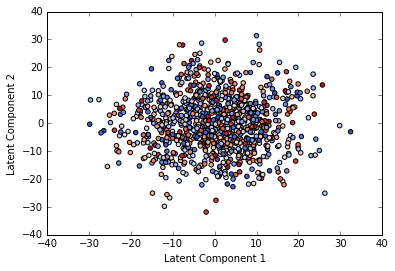

In [17]:
%matplotlib inline
plt.scatter(latent_sample1,latent_sample2, c=cmap)
plt.xlabel("Latent Component 1")
plt.ylabel("Latent Component 2")

# PCA with SciKit learn (comparison)

Below, we run a simple (out-of-the-box) PCA to compare the results. We simple plot the first and seond component.

In [24]:
pca = PCA(n_components=2)
pca.fit([x,y,z]) 


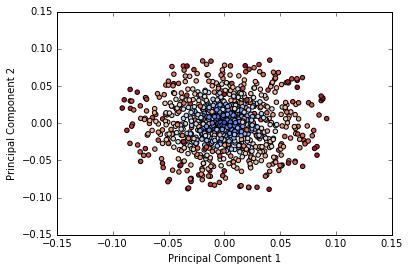

In [28]:
plt.scatter(pca.components_[0,:],pca.components_[1,:], c=cmap)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

Fig. 2: Principal Component Analysis. We plot the 2 latent components and color by Iris species.